## Script de création de graphe
cf base de donnée CAIDA : https://publicdata.caida.org/datasets/as-relationships/serial-2/


**README :**
 
The as-rel file contain p2p and p2c relationships.
The format is:

`<provider-as>|<customer-as>|-1` <br>
`<peer-as>|<peer-as>|0|<source>`

    
Example : 
    

`1|2|-1|bgp`             <br>
`1|11537|0|bgp`          <br>
`1|200863|-1|bgp`        <br>
`1|267222|0|bgp`         <br>
`2|21954|0|bgp`          <br>
`2|29447|-1|bgp`         <br>
`2|200863|-1|bgp`        <br>
`3|293|0|bgp`            <br>
`3|6939|0|bgp`           <br>
`3|37619|0|bgp`          <br>
`3|133967|0|bgp`         <br>
`3|206960|0|bgp`         <br>
`3|264381|-1|bgp`        <br>
`4|7633|-1|bgp`          <br>


About 500 000 lignes of this type



Data classified among 3 classes :

``Content``          <br>
``Transit/Access``   <br>
``Enterprise``       <br>

In [173]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Common imports
import numpy as np
import os
import pandas as pd
import networkx as nx
import pickle
os.popen("export DGLBACKEND=pytorch")
#import dgl as dgl
import time
from sklearn import preprocessing

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from numpy import arange

#### Définition diverses de fonction (utilisant du bash) permettant de vérifier que le graphe a été bien créé

In [174]:
# Fichier au choix parmi ceux de ./data/CAIDA_AS_RELATIONSHIP

#FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20200101.as-rel2.txt'
FILE_PATH='./data/CAIDA_AS_RELATIONSHIP/20210301.as-rel2.txt'

In [175]:
def encadre(message):
    print("\n****************************")
    print(message)
    print("****************************\n")

def nb_nodes_of_file(file):
    return int(os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read())
    
#def nb_edges_of_file(file):
#    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq | wc -l" %file).read()

def list_nodes_sorted(file):
    return os.popen("cat %s | grep \"^[0-9][0-9]*\" | awk -F \"|\" '{ print $1 \"\\n\" $2 }' | sort -h | uniq" %file).read()

def nb_peering_customer_provider(ASN):
    nb_peerings =  os.popen("cat %s | grep \"^%s|\||%s|\" | grep -v \".*\-1\" | wc -l" % (FILE_PATH, ASN, ASN)).read()
    nb_customers = os.popen("cat %s | grep \"^%s|.*\-1\" |wc -l " % (FILE_PATH, ASN)).read()
    nb_providers = os.popen("cat %s | grep \"|%s|\-1\" | wc -l" % (FILE_PATH, ASN)).read()
    return nb_peerings.split("\n")[0], nb_customers.split("\n")[0], nb_providers.split("\n")[0]

def csv_dataset(file):
    return os.popen()

In [176]:
nb_nodes_file = nb_nodes_of_file(FILE_PATH)
print("Nb nodes of file : " + str(nb_nodes_file))

Nb nodes of file : 71434


In [177]:
nb_type_links = nb_peering_customer_provider(4)
print("Link types and number (p2p, c, p) of node index 4 : " + str(nb_type_links))

Link types and number (p2p, c, p) of node index 4 : ('2', '1', '12')


### Panda Datasets

In [178]:
#AS_dataset_202001 = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20200101.as2types.txt', sep='|')
AS_dataset = pd.read_csv('data/CAIDA_AS_CLASSIFICATION/20210301.as2types.txt', sep='|')

### ATTENTION : si erreur, lancer le script `./sort_datasets.sh -h`

# Vérif nombre de noeuds
assert (len(AS_dataset.index) == nb_nodes_file)

In [179]:
AS_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71434 entries, 0 to 71433
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ASN           71434 non-null  int64 
 1   source_label  71434 non-null  object
 2   label         71434 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [180]:
print(AS_dataset["label"].value_counts())
print("\n")
print(AS_dataset["source_label"].value_counts())

Transit/Access    54367
Enterprise        13632
Content            3435
Name: label, dtype: int64


CAIDA_class     57895
peerDB_class    12889
manual_class      650
Name: source_label, dtype: int64


<AxesSubplot:>

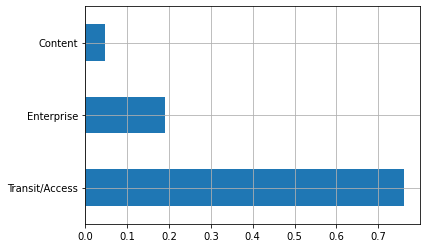

In [181]:
AS_dataset["label"].value_counts(normalize=True).plot(kind='barh', grid=True)

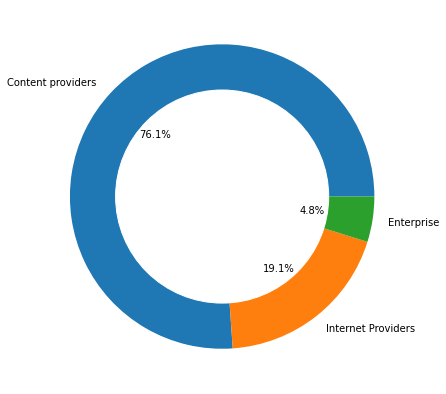

In [182]:
my_circle = plt.Circle( (0,0), 0.7, color='white')
plt.pie(AS_dataset['label'].value_counts(), labels=['Content providers ', 'Internet Providers', 'Enterprise'],autopct='%1.1f%%')
fig = plt.gcf()
fig.gca().add_artist(my_circle)
fig.set_size_inches(7,7)
plt.show()

In [185]:
AS_dataset.head(10)

,ASN,source_label,label
0,1,CAIDA_class,Transit/Access
1,2,CAIDA_class,Transit/Access
2,3,CAIDA_class,Transit/Access
3,4,CAIDA_class,Transit/Access
4,5,CAIDA_class,Enterprise
5,6,CAIDA_class,Content
6,7,CAIDA_class,Enterprise
7,8,CAIDA_class,Transit/Access
8,9,CAIDA_class,Transit/Access
9,10,CAIDA_class,Transit/Access


In [74]:
def dictiongraph(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(sorted(list(set(dictio))), l))
    return dictiofinal

In [75]:
def creation_graph(fichier_texte):
    G = nx.Graph() 
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= str(asn1) + '|p2p|' +str(asn2))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=str(asn1) + '|p2c|' +str(asn2))
        except ValueError:
            pass
    return G

In [76]:
G = creation_graph(FILE_PATH)

In [77]:
def creation_graph_dirige(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                
        except ValueError:
            pass
    return G

In [78]:
G_directed = creation_graph_dirige(FILE_PATH)

In [79]:
def creation_graph_dirige_inverse(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,asn=num_as)
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :

                G.add_edge(dictio[asn2],dictio[asn1],type= 3/3)
                
        except ValueError:
            pass
    return G

In [80]:
G_directed_inverse = creation_graph_dirige_inverse(FILE_PATH)

In [81]:
def label_into_int(label):
    if (label == 'Content'):
        int_label = 0
    elif (label == 'Transit/Access'):
        int_label = 1
    elif (label == 'Enterprise'):
        int_label = 2
    return int_label

In [82]:
def creation_graph_float(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        #print("G add node : index " + str(i) + ", asn : " + str(num_as) + ", " + AS_dataset['label'][i] + " => " + str(label_into_int(AS_dataset['label'][i])))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 2/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 2/3)
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type= 3/3)
                G.add_edge(dictio[asn2],dictio[asn1],type= 1/3)
        except ValueError:
            pass
    return G

In [83]:
G_float =creation_graph_float(FILE_PATH)

In [84]:
def creation_graph_array(fichier_texte):
    G = nx.DiGraph()
    fichier = open(fichier_texte,"r")
    cpt = 0
    memoire = -1
    dictio = dictiongraph(fichier_texte)
    i=0
    #Ajout de tous les noeuds
    for num_as in dictio :
        G.add_node(i,label=label_into_int(AS_dataset['label'][i]))
        i+=1
    #Ajout des arêtes
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            info = int(tabligne[2])
            if info == 0 :
                G.add_edge(dictio[asn1],dictio[asn2],type= np.array([0,1,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type= np.array([0,1,0]))
            elif info == -1 :
                G.add_edge(dictio[asn1],dictio[asn2],type=np.array([1,0,0]))
                G.add_edge(dictio[asn2],dictio[asn1],type=np.array([0,0,1]))
        except ValueError:
            pass
    return G

In [85]:
G_array=creation_graph_array(FILE_PATH)

In [171]:
nb_nodes_graph = G.number_of_nodes()
nb_edges_graph = G.number_of_edges()

print("Graph number of nodes :   "  + str(nb_nodes_graph))
print("Graph number of edges :  " + str(nb_edges_graph))

assert(nb_nodes_graph == int(nb_nodes_of_file(FILE_PATH)))
print("\nASSERT NB NODES OK")

Graph number of nodes :   71434
Graph number of edges :  489716

ASSERT NB NODES OK


- ### Ajout des colonnes `page_rank_not_directed`, `page_rank_directed` et `degree_centrality`

In [87]:
list_pageRank = nx.pagerank(G).values()
list_pageRank_directed = nx.pagerank(G_directed).values()
list_pageRank_directed_inverse = nx.pagerank(G_directed_inverse).values()
list_degreeCentrality = nx.degree_centrality(G).values()

- #### Scale de la donnée `page_rank_not_directed`

In [88]:
AS_dataset['page_rank_not_directed'] = list_pageRank

count    71434.000000
mean         0.000014
std          0.000106
min          0.000002
25%          0.000004
50%          0.000005
75%          0.000007
max          0.010813
Name: page_rank_not_directed, dtype: float64


Text(0, 0.5, '%')

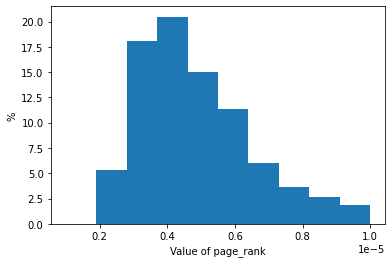

In [89]:
print(AS_dataset['page_rank_not_directed'].describe())

plt.hist(AS_dataset['page_rank_not_directed'], 
         range=(1e-6,1e-5), 
         weights=100*(np.ones(len(AS_dataset['page_rank_not_directed']))/len(AS_dataset['page_rank_not_directed'])))
plt.xlabel("Value of page_rank")
plt.ylabel("%")

In [147]:
AS_dataset['page_rank_not_directed'] = [element * 20000 for element in list_pageRank]

count    71434.000000
mean         0.279979
std          2.119527
min          0.046870
25%          0.075614
50%          0.098458
75%          0.141052
max        216.259820
Name: page_rank_not_directed, dtype: float64


Text(0, 0.5, '%')

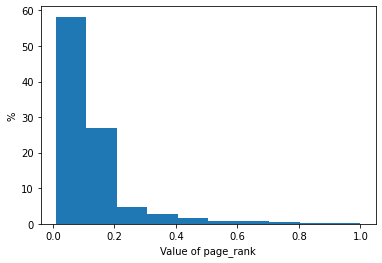

In [149]:
print(AS_dataset['page_rank_not_directed'].describe())

plt.hist(AS_dataset['page_rank_not_directed'], 
         range=(1e-2,1e0), 
         weights=100*(np.ones(len(AS_dataset['page_rank_not_directed']))/len(AS_dataset['page_rank_not_directed'])))
plt.xlabel("Value of page_rank")
plt.ylabel("%")

- #### Scale de la donnée `page_rank_directed`

In [151]:
AS_dataset['page_rank_directed'] = list_pageRank_directed

count    71434.000000
mean         0.000014
std          0.000066
min          0.000008
25%          0.000009
50%          0.000009
75%          0.000011
max          0.009921
Name: page_rank_directed, dtype: float64


Text(0, 0.5, '%')

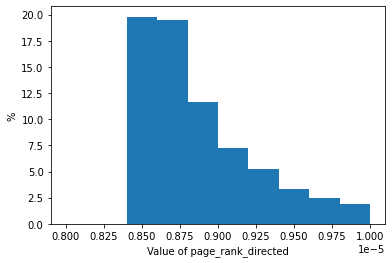

In [152]:
print(AS_dataset['page_rank_directed'].describe())

plt.hist(AS_dataset['page_rank_directed'], 
         range=(8e-6,1e-5), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed']))/len(AS_dataset['page_rank_directed'])))
plt.xlabel("Value of page_rank_directed")
plt.ylabel("%")

In [153]:
AS_dataset['page_rank_directed'] = [element * 45000 for element in list_pageRank_directed]

count    71434.000000
mean         0.629952
std          2.954625
min          0.378938
25%          0.388982
50%          0.404204
75%          0.473491
max        446.433465
Name: page_rank_directed, dtype: float64


Text(0, 0.5, '%')

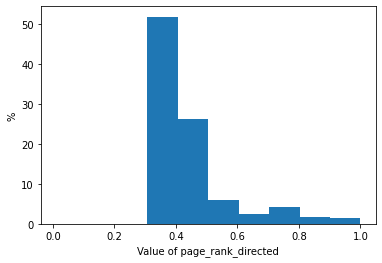

In [155]:
print(AS_dataset['page_rank_directed'].describe())

plt.hist(AS_dataset['page_rank_directed'], 
         range=(1e-2,1e0), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed']))/len(AS_dataset['page_rank_directed'])))
plt.xlabel("Value of page_rank_directed")
plt.ylabel("%")

- #### Scale de la donnée `page_rank_directed_inverse`

In [159]:
AS_dataset['page_rank_directed_inverse'] = list_pageRank_directed_inverse

count    71434.000000
mean         0.000014
std          0.000122
min          0.000002
25%          0.000002
50%          0.000002
75%          0.000002
max          0.010811
Name: page_rank_directed_inverse, dtype: float64


Text(0, 0.5, '%')

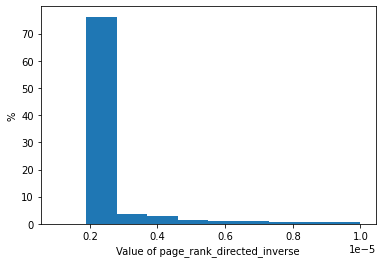

In [160]:
print(AS_dataset['page_rank_directed_inverse'].describe())

plt.hist(AS_dataset['page_rank_directed_inverse'], 
         range=(1e-6,1e-5), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed_inverse']))/len(AS_dataset['page_rank_directed_inverse'])))
plt.xlabel("Value of page_rank_directed_inverse")
plt.ylabel("%")

In [161]:
AS_dataset['page_rank_directed_inverse'] = [element * 40000 for element in list_pageRank_directed_inverse]

count    71434.000000
mean         0.559957
std          4.880359
min          0.083994
25%          0.083994
50%          0.083994
75%          0.083994
max        432.446005
Name: page_rank_directed_inverse, dtype: float64


Text(0, 0.5, '%')

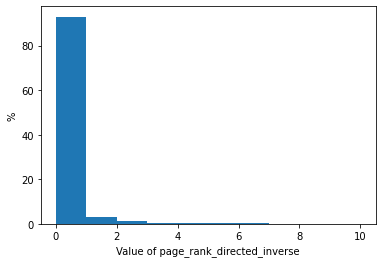

In [166]:
print(AS_dataset['page_rank_directed_inverse'].describe())

plt.hist(AS_dataset['page_rank_directed_inverse'], 
         range=(1e-2,1e1), 
         weights=100*(np.ones(len(AS_dataset['page_rank_directed_inverse']))/len(AS_dataset['page_rank_directed_inverse'])))
plt.xlabel("Value of page_rank_directed_inverse")
plt.ylabel("%")

- #### Scale de la donnée `degree_centrality`

In [100]:
AS_dataset['degree_centrality'] = list_degreeCentrality

count    71434.000000
mean         0.000192
std          0.001498
min          0.000014
25%          0.000014
50%          0.000028
75%          0.000042
max          0.127154
Name: degree_centrality, dtype: float64


Text(0, 0.5, '%')

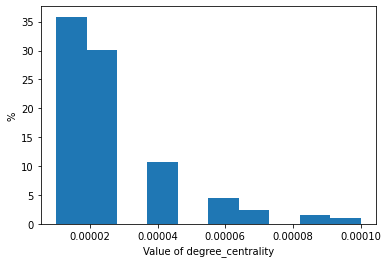

In [101]:
print(AS_dataset['degree_centrality'].describe())

plt.hist(AS_dataset['degree_centrality'], 
         range=(1e-5,1e-4), 
         weights=100*(np.ones(len(AS_dataset['degree_centrality']))/len(AS_dataset['degree_centrality'])))
plt.xlabel("Value of degree_centrality")
plt.ylabel("%")

In [102]:
AS_dataset['degree_centrality'] = [element * 10000 for element in list_degreeCentrality]

count    71434.000000
mean         1.919422
std         14.981509
min          0.139991
25%          0.139991
50%          0.279983
75%          0.419974
max       1271.541164
Name: degree_centrality, dtype: float64


Text(0, 0.5, '%')

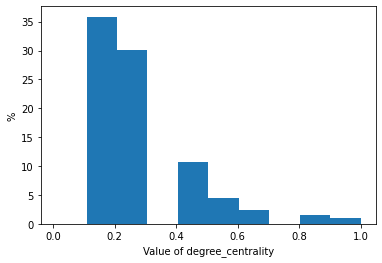

In [103]:
print(AS_dataset['degree_centrality'].describe())

plt.hist(AS_dataset['degree_centrality'], 
         range=(1e-2,1e0), 
         weights=100*(np.ones(len(AS_dataset['degree_centrality']))/len(AS_dataset['degree_centrality'])))
plt.xlabel("Value of degree_centrality")
plt.ylabel("%")

In [104]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality
0,1,CAIDA_class,Transit/Access,2.501938,3.688530,0.675913,1.959878
1,2,CAIDA_class,Transit/Access,3.436612,7.292742,0.169510,2.939818
2,3,CAIDA_class,Transit/Access,3.119256,2.997638,3.691148,2.799826
3,4,CAIDA_class,Transit/Access,2.848648,4.188328,0.155139,2.099870
4,5,CAIDA_class,Enterprise,1.597862,5.659595,0.142545,0.979939


In [105]:
def dictiongraph_Nbnoeud_Asn(fichier_texte):
    fichier = open(fichier_texte,"r")
    dictio = []
    memoire=-1
    for ligne in fichier:
        tabligne = ligne.split("|")
        try:
            asn1 = int(tabligne[0])
            asn2 = int(tabligne[1])
            if asn1 != memoire:
                dictio.append(asn1)
                memoire = asn1
            dictio.append(asn2)
        except ValueError:
            pass
    l = arange(len(list(set(dictio))))
    dictiofinal =dict_from_list = dict(zip(l, sorted(list(set(dictio)))))
    return dictiofinal
Dictio_noeud_as = dictiongraph_Nbnoeud_Asn(FILE_PATH)

In [106]:
def nbtypevoisins2(G):
    nbNoeuds = G.number_of_nodes()
    Liste_Nb_Voisins_Peering = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Customer = np.zeros(nbNoeuds)
    Liste_Nb_Voisins_Provider = np.zeros(nbNoeuds)
    for i in range(nbNoeuds):
        for j in range(len(G[i])) :
            infos = list(G[i].values())[j]["type"].split("|")
            #print(infos)
            type_lien = infos[1]
            if type_lien == "p2p":

                Liste_Nb_Voisins_Peering[i] +=1
                #Liste_Nb_Voisins_Peering[dictio_as_noeud[int(asn2)]] +=1
            elif type_lien == "p2c":
                asn1 = infos[0]
                asn2 = infos[2]
                if int(asn2) == int(Dictio_noeud_as[i]) :
                     Liste_Nb_Voisins_Provider[i]+=1                
                else :
                    Liste_Nb_Voisins_Customer[i]+=1

        #print(i)

    return Liste_Nb_Voisins_Peering, Liste_Nb_Voisins_Customer, Liste_Nb_Voisins_Provider 
                
#### TEMPS D'EXECUTION : 5min ~
L1,L2,L3=nbtypevoisins2(G) 

- ### Vérification de la conformité des listes L1, L2 et L3 par rapport au graphe

In [107]:
max_degree_list = max(L1 + L2 + L3)
highest_degree_graph = max(list(dict(G.degree()).values()))
index_max = list(dict(G.degree()).values()).index(highest_degree_graph)
ASN_max = list(Dictio_noeud_as.values())[index_max]

print("Max degree list : "  + str(max_degree_list))
print("Max degree index : " + str(index_max) + ", max degree ASN : " + str(ASN_max))
print("Max degree graph : " + str(highest_degree_graph))

assert (max_degree_list == highest_degree_graph)
print("\nASSERT MAX DEGREE OK")

Max degree list : 9083.0
Max degree index : 2475, max degree ASN : 6939
Max degree graph : 9083

ASSERT MAX DEGREE OK


In [108]:
# Extraction des maximum de p2p link, customer link et provider link
max_p2p, index_max_p2p = np.max(L1), np.argmax(L1)
max_c,   index_max_c   = np.max(L2), np.argmax(L2)
max_p,   index_max_p   = np.max(L3), np.argmax(L3)

print("Max p2p links          : " + str(max_p2p) + ", index : " + str(index_max_p2p) + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p2p]))
print("Max nb customer links  : " + str(max_c)   + ", index : " + str(index_max_c)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_c]))
print("Max nb provider links  : " + str(max_p)   + ", index : " + str(index_max_p)   + ", ASN : " + str(list(Dictio_noeud_as.values())[index_max_p]))

Max p2p links          : 7250.0, index : 2475, ASN : 6939
Max nb customer links  : 6237.0, index : 107, ASN : 174
Max nb provider links  : 137.0, index : 11176, ASN : 20940


In [109]:
AS_dataset.iloc[index_max_p2p]

ASN                                     6939
source_label                    peerDB_class
label                         Transit/Access
page_rank_not_directed             835.02645
page_rank_directed                446.433465
page_rank_directed_inverse        432.446005
degree_centrality                1271.541164
Name: 2475, dtype: object

In [110]:
AS_dataset.iloc[index_max_c]

ASN                                      174
source_label                    peerDB_class
label                         Transit/Access
page_rank_not_directed           1081.299099
page_rank_directed                  5.826498
page_rank_directed_inverse        371.868033
degree_centrality                 889.644842
Name: 107, dtype: object

In [111]:
AS_dataset.iloc[index_max_p]

ASN                                  20940
source_label                  peerDB_class
label                              Content
page_rank_not_directed           54.140336
page_rank_directed               16.255773
page_rank_directed_inverse       29.373016
degree_centrality               132.711772
Name: 11176, dtype: object

- ### Ajout de la colonne `degree_normalized` définit par le log du degré de chaque noeud

In [112]:
List_degree = L1 + L2 + L3

AS_dataset['degree_normalized'] = np.log10(List_degree)

In [113]:
AS_dataset['degree_normalized'].describe()

count    71434.000000
mean         0.410693
std          0.514509
min          0.000000
25%          0.000000
50%          0.301030
75%          0.477121
max          3.958229
Name: degree_normalized, dtype: float64

In [114]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized
0,1,CAIDA_class,Transit/Access,2.501938,3.688530,0.675913,1.959878,1.146128
1,2,CAIDA_class,Transit/Access,3.436612,7.292742,0.169510,2.939818,1.322219
2,3,CAIDA_class,Transit/Access,3.119256,2.997638,3.691148,2.799826,1.301030
3,4,CAIDA_class,Transit/Access,2.848648,4.188328,0.155139,2.099870,1.176091
4,5,CAIDA_class,Enterprise,1.597862,5.659595,0.142545,0.979939,0.845098


- ### Ajout des colonnes `ratio_peering`, `ratio_customer` et `ratio_provider`

In [115]:
AS_dataset['ratio_peering']  = np.log(L1 + 1)

AS_dataset['ratio_customer'] = np.log(L2 + 1)

AS_dataset['ratio_provider'] = np.log10(L3 + 1)

In [116]:
print(AS_dataset['ratio_peering'].value_counts())
print(AS_dataset['ratio_customer'].value_counts())
print(AS_dataset['ratio_provider'].value_counts())

0.000000    58900
0.693147     2689
1.098612      858
1.386294      542
1.609438      401
            ...  
6.419995        1
5.257495        1
6.525030        1
5.370638        1
5.356586        1
Name: ratio_peering, Length: 535, dtype: int64
0.000000    60531
0.693147     4429
1.098612     1685
1.386294      872
1.609438      610
            ...  
5.407172        1
5.379897        1
7.601902        1
4.234107        1
4.564348        1
Name: ratio_customer, Length: 247, dtype: int64
0.301030    29226
0.477121    25250
0.602060     9225
0.698970     3651
0.778151     1612
0.845098      787
0.000000      425
0.903090      384
0.954243      278
1.000000      185
1.041393       89
1.079181       57
1.113943       56
1.146128       41
1.176091       26
1.204120       20
1.230449       16
1.255273       15
1.278754       15
1.342423       12
1.322219       10
1.361728        7
1.380211        4
1.301030        4
1.505150        4
1.491362        4
1.579784        3
1.518514        2
1.740

In [117]:
AS_dataset['ratio_peering'].describe()

count    71434.000000
mean         0.434111
std          1.136506
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.888895
Name: ratio_peering, dtype: float64

In [118]:
AS_dataset['ratio_customer'].describe()

count    71434.000000
mean         0.228704
std          0.677011
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.738415
Name: ratio_customer, dtype: float64

In [119]:
AS_dataset['ratio_provider'].describe()

count    71434.000000
mean         0.450143
std          0.164351
min          0.000000
25%          0.301030
50%          0.477121
75%          0.477121
max          2.139879
Name: ratio_provider, dtype: float64

In [120]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
0,1,CAIDA_class,Transit/Access,2.501938,3.688530,0.675913,1.959878,1.146128,1.098612,1.098612,1.041393
1,2,CAIDA_class,Transit/Access,3.436612,7.292742,0.169510,2.939818,1.322219,0.693147,1.098612,1.278754
2,3,CAIDA_class,Transit/Access,3.119256,2.997638,3.691148,2.799826,1.301030,1.791759,0.693147,1.176091
3,4,CAIDA_class,Transit/Access,2.848648,4.188328,0.155139,2.099870,1.176091,1.098612,0.693147,1.113943
4,5,CAIDA_class,Enterprise,1.597862,5.659595,0.142545,0.979939,0.845098,1.098612,0.000000,0.778151


In [121]:
AS_dataset [AS_dataset['ASN'] == 6939]

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
2475,6939,peerDB_class,Transit/Access,835.02645,446.433465,432.446005,1271.541164,3.958229,8.888895,7.513164,0.477121


In [122]:
index_max_p2p = AS_dataset.index [AS_dataset['ASN'] == 6939]
print("Nb p2p : " + str(int(L1[index_max_p2p]))
      + "\nNb c   : " + str(int(L2[index_max_p2p])) 
      + "\nNb p   : " + str(int(L3[index_max_p2p])))

Nb p2p : 7250
Nb c   : 1831
Nb p   : 2


In [ ]:
#AS_dataset['peering_links']  = L1
#AS_dataset['customer_links'] = L2
#AS_dataset['provider_links'] = L3

#AS_dataset['peering_links_mal_scaled']    = AS_dataset['peering_links']/max_p2p
#AS_dataset['customer_links_mal_scaled']   = AS_dataset['customer_links']/max_c
#AS_dataset['provider_links_mal_scaled']   = AS_dataset['provider_links']/max_p

#AS_dataset['peering_centre_reduit']  = sklearn.preprocessing.scale(AS_dataset['peering_links'])
#AS_dataset['customer_centre_reduit'] = sklearn.preprocessing.scale(AS_dataset['customer_links'])
#AS_dataset['provider_centre_reduit'] = sklearn.preprocessing.scale(AS_dataset['provider_links'])

In [ ]:
AS_dataset['peering_links'].describe()

In [ ]:
AS_dataset['customer_links'].describe()

In [ ]:
AS_dataset['provider_links'].describe()

In [ ]:
AS_dataset['peering_centre_reduit'].describe()

In [ ]:
AS_dataset['peering_centre_reduit'].quantile(0.99)

In [ ]:
AS_dataset['customer_centre_reduit'].describe()

In [ ]:
AS_dataset['provider_centre_reduit'].describe()

In [ ]:
AS_dataset['peering_links_mal_scaled'].describe()

In [ ]:
AS_dataset['customer_links_mal_scaled'].describe()

In [ ]:
AS_dataset['provider_links_mal_scaled'].describe()

In [ ]:
AS_dataset['peering_links_mal_scaled'].value_counts()

In [ ]:
AS_dataset['customer_links'].describe()

In [ ]:
AS_dataset['provider_links'].describe()

In [ ]:
AS_dataset['peering_links'] = L1/max_p2p
AS_dataset['customer_links'] = L2/max_c
AS_dataset['provider_links'] = L3/max_p

assert(AS_dataset['peering_links'][index_max_p2p] == 1)
assert(AS_dataset['customer_links'][index_max_c] == 1)
assert(AS_dataset['provider_links'][index_max_p] == 1)

In [123]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
0,1,CAIDA_class,Transit/Access,2.501938,3.688530,0.675913,1.959878,1.146128,1.098612,1.098612,1.041393
1,2,CAIDA_class,Transit/Access,3.436612,7.292742,0.169510,2.939818,1.322219,0.693147,1.098612,1.278754
2,3,CAIDA_class,Transit/Access,3.119256,2.997638,3.691148,2.799826,1.301030,1.791759,0.693147,1.176091
3,4,CAIDA_class,Transit/Access,2.848648,4.188328,0.155139,2.099870,1.176091,1.098612,0.693147,1.113943
4,5,CAIDA_class,Enterprise,1.597862,5.659595,0.142545,0.979939,0.845098,1.098612,0.000000,0.778151


- ### Modification de la colonne `label`

On transforme la **catégorie non ordinale** en 3 classes entières :
 - *Content* ⇔ $0$
 - *Transit/Access* ⇔ $1$
 - *Enterprise* ⇔ $2$

In [124]:
AS_dataset['label'] = AS_dataset['label'].map({'Content': 0, 'Transit/Access': 1, 'Enterprise': 2})

In [168]:
AS_dataset.head()

,ASN,source_label,label,page_rank_not_directed,page_rank_directed,page_rank_directed_inverse,degree_centrality,degree_normalized,ratio_peering,ratio_customer,ratio_provider
0,1,CAIDA_class,1,0.500388,3.688530,0.675913,1.959878,1.146128,1.098612,1.098612,1.041393
1,2,CAIDA_class,1,0.687322,7.292742,0.169510,2.939818,1.322219,0.693147,1.098612,1.278754
2,3,CAIDA_class,1,0.623851,2.997638,3.691148,2.799826,1.301030,1.791759,0.693147,1.176091
3,4,CAIDA_class,1,0.569730,4.188328,0.155139,2.099870,1.176091,1.098612,0.693147,1.113943
4,5,CAIDA_class,2,0.319572,5.659595,0.142545,0.979939,0.845098,1.098612,0.000000,0.778151


### Exportation des données : `dataset` et `graph`

On crée 4 fichiers : 
- Le `dataset`complet 
- Le `graphe` nx au format pickle
- Le `graphe_float` nx au format pickle
- Le `graphe_array` nx au format pickle

In [167]:
# Exportation des données

suffix = FILE_PATH.split('/')[3].split('.')[0]

AS_dataset.to_csv('data_GCN/dataset_v4_'+suffix+'.csv', index=False)
nx.write_gpickle(G, 'data_GCN/graph_'+suffix+'.pickle')
nx.write_gpickle(G_float, 'data_GCN/graph_float_'+suffix+'.pickle')
nx.write_gpickle(G_array, 'data_GCN/graph_array_'+suffix+'.pickle')